In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from collections import Counter
from funcs import *
from extract_const import *
from mpf_funcs import *
from scipy import stats

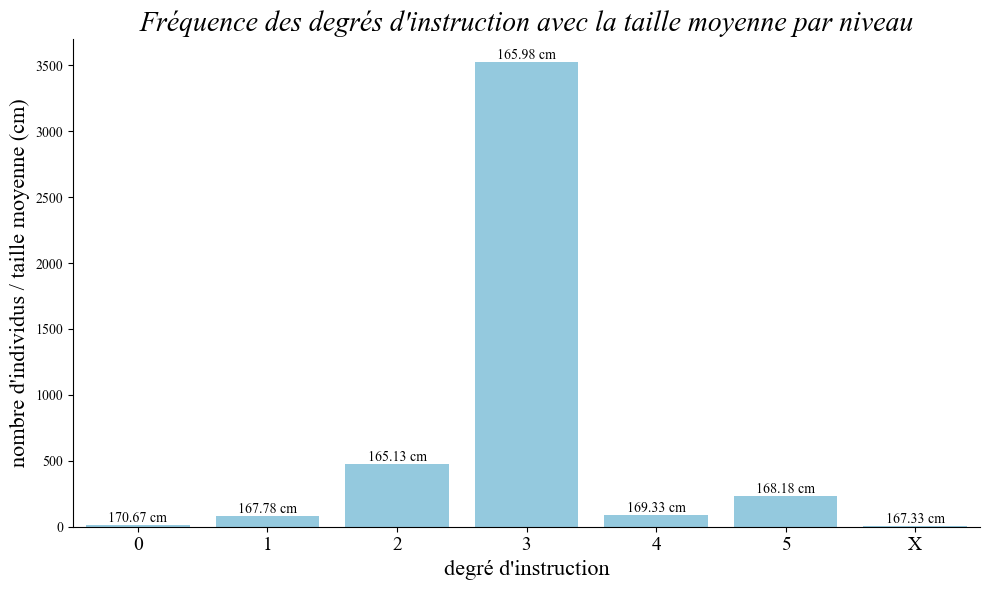

In [2]:
# CSV des registres matricules de la Seine
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df_other = pd.read_csv('data/primary/edited_geotagged_bertha.csv', sep=',') #On recupure l'information geocodée
df = pd.merge(df, df_other[['pays']], left_index=True, right_index=True)
df['degre_instruction'] = df['instruction'].apply(lambda x: extract_inst(x) if isinstance(x, str) else x)
df = extract_height(df)
education_counts = df['degre_instruction'].value_counts().reset_index()
education_counts.columns = ['degre_instruction', 'Frequency']

# Get average height for each education level
average_heights = df.groupby('degre_instruction')['taille (cm)'].mean().reset_index()

# Merge the two DataFrames on education level
merged_data = pd.merge(education_counts, average_heights, on='degre_instruction')

# Sort merged data by education level in ascending order
merged_data.sort_values(by='degre_instruction', inplace=True)

# Plot
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 6))
sns.barplot(x='degre_instruction', y='Frequency', data=merged_data, color='skyblue', label="Nombre d'individus")
sns.despine()
for i, row in enumerate(merged_data.itertuples(), start=0):
    plt.text(i, row.Frequency, f'{row._3:.2f} cm', ha='center', va='bottom', color='black')
plt.xlabel("degré d'instruction",fontsize=16)
plt.ylabel("nombre d'individus / taille moyenne (cm)",fontsize=16)
plt.title("Fréquence des degrés d'instruction avec la taille moyenne par niveau", style='italic', fontsize=20)
plt.xticks(range(len(merged_data)), merged_data['degre_instruction'], fontsize=14)
plt.tight_layout()
plt.legend('',frameon=False)
plt.savefig('data/primary/figures/instructionXtaille.png', dpi=300)
plt.show()

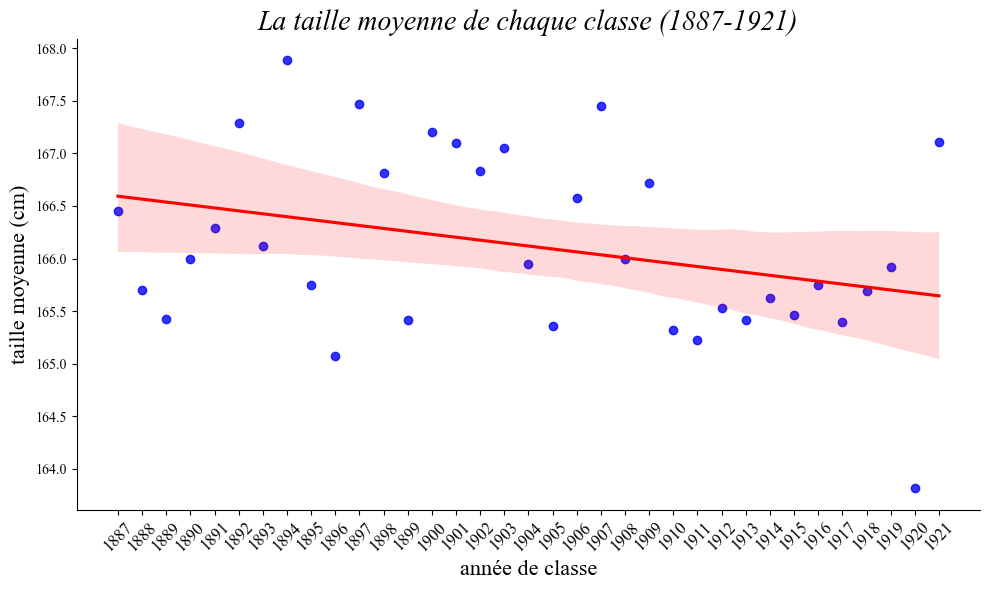

In [3]:
# CSV des registres matricules de la Seine
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['année_classe'] = df['num_mat'].apply(lambda x: extract_classe(x) if isinstance(x, str) else x)
df = df.apply(fill_classe, axis=1)
df['année_classe'] = pd.to_numeric(df['année_classe'], errors='coerce')
df = extract_height(df)

# On rajoute les informations de la base MPF
merged_df = pd.read_csv('data/primary/merged_mpf.csv', sep=',')
merged_df = merged_df[['labat_id', 'id_mention_intitule', 'classe', 'recrutement_matricule', 'id_recrutement_bureau_intitule',
                  'id_grade_intitule', 'id_unite_intitule', 'deces_jour_mois_annee', 'id_deces_lieu_intitule',
                  'id_deces_departement_intitule', 'id_deces_pays_intitule']]
merged_df.columns = ['mpf_' + col if col != 'labat_id' else col for col in merged_df.columns]
check_labat_ids(merged_df, df)
merged_df['labat_id'] = merged_df['labat_id'].astype(df['labat_id'].dtype)
df = df.join(merged_df.set_index('labat_id'), on='labat_id', how='left')

# On nettoie les données de la base MPF
df['mpf_classe_cleaned'] = df['mpf_classe'].apply(lambda x: extract_year(x) if isinstance(x, str) else x)
df['mpf_classe_cleaned'] = pd.to_numeric(df['mpf_classe_cleaned'], errors='coerce')
df['année_classe'] = df.apply(lambda row: row['mpf_classe_cleaned'] if pd.notna(row['mpf_classe_cleaned']) else row['année_classe'], axis=1)
plt.rcParams["font.family"] = "Times New Roman"

# Assuming you have already calculated the average height for each batch year
average_height_by_classe = df['taille (cm)'].groupby(df['année_classe']).mean()

# Filter the data for the years 1887 to 1921
average_height_filtered = average_height_by_classe.loc[1887:1921]


plt.rcParams["font.family"] = "Times New Roman"
# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=average_height_filtered.index, y=average_height_filtered.values, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

# Set axis labels and title
plt.xlabel('année de classe', fontsize=16)
plt.ylabel('taille moyenne (cm)',fontsize=16)
plt.title('La taille moyenne de chaque classe (1887-1921)', style='italic', fontsize=20)

# Set x-axis ticks
plt.xticks(range(1887, 1922), rotation=45, fontsize=12)


# Despine the figure
sns.despine()

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/classeXtaille.png', dpi=300)
plt.show()

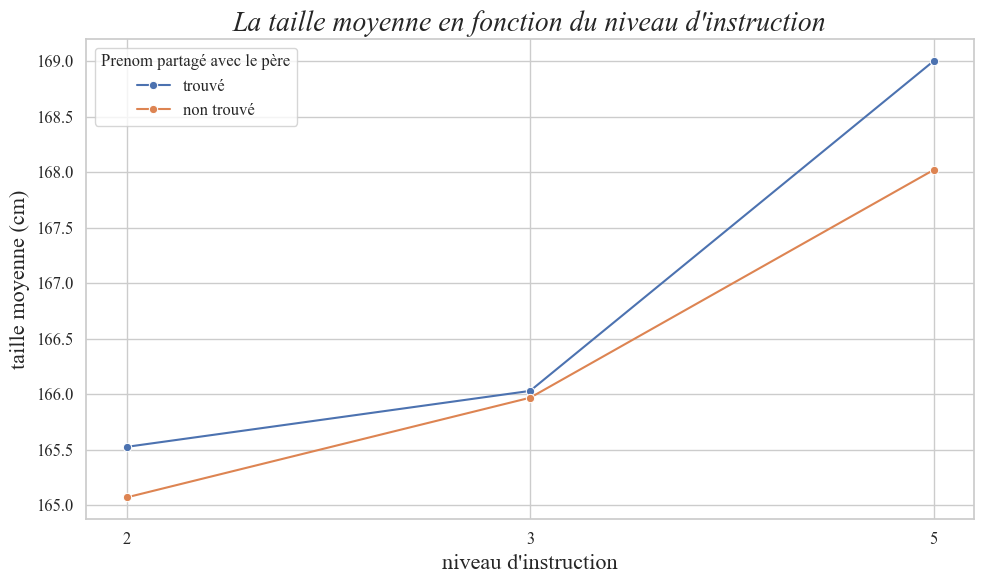

In [47]:
# CSV des registres matricules de la Seine
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df_other = pd.read_csv('data/primary/edited_geotagged_bertha.csv', sep=',') #On recupure l'information geocodée
df = pd.merge(df, df_other[['pays']], left_index=True, right_index=True)
df['origine'] = df['pays'].apply(categorize_country)
df = extract_prenom(df)
df['junior'] = df.apply(extract_junior, axis=1)
df['degre_instruction'] = df['instruction'].apply(lambda x: extract_inst(x) if isinstance(x, str) else x)
df = extract_height(df)

#Get data
junior_average_height = df[df['junior'] == True].groupby('degre_instruction')['taille (cm)'].mean()
junior_average_height_count = df[df['junior'] == True].groupby('degre_instruction')['taille (cm)'].count()
normal_average_height = df[df['junior'] == False].groupby('degre_instruction')['taille (cm)'].mean()
normal_average_height_count = df[df['junior'] == False].groupby('degre_instruction')['taille (cm)'].count()
data_junior = pd.concat([junior_average_height, junior_average_height_count], axis=1)
data_junior.columns = ['Average Height', 'Count']

data_normal = pd.concat([normal_average_height, normal_average_height_count], axis=1)
data_normal.columns = ['Average Height', 'Count']


# Filter the data to include only education levels 2, 3, and 5
data_junior = data_junior[data_junior.index.isin(['2', '3', '5'])]
data_normal = data_normal[data_normal.index.isin(['2', '3', '5'])]

# Plot
plt.figure(figsize=(10, 6))

# Plot lines for each geographic origin
sns.lineplot(x=data_junior.index, y='Average Height', data=data_junior, label='trouvé', marker='o')
sns.lineplot(x=data_normal.index, y='Average Height', data=data_normal, label='non trouvé', marker='o')


# Set axis labels and title
plt.xlabel("niveau d'instruction",fontsize=16)
plt.ylabel('taille moyenne (cm)',fontsize=16)
plt.title("La taille moyenne en fonction du niveau d'instruction", style='italic', fontsize=20)

# Show legend
plt.legend(title='Prenom partagé avec le père', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/junior.png', dpi=300)
plt.show()

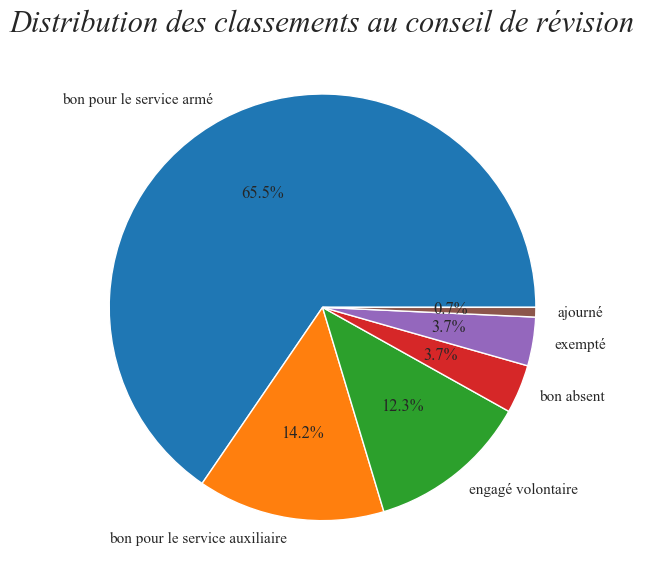

In [48]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['classement'] = df['decision'].apply(lambda x: extract_decision(x, DECISION) if isinstance(x, str) else x)
classement_counts = df['classement'].value_counts()
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
colors = sns.color_palette('tab10')
plt.rcParams["font.family"] = "Times New Roman"
plt.pie(classement_counts, labels=classement_counts.index, autopct='%1.1f%%', colors = colors)

# Add title
plt.title('Distribution des classements au conseil de révision', style='italic', fontsize=22)

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/classement.png', dpi=300)
plt.show()

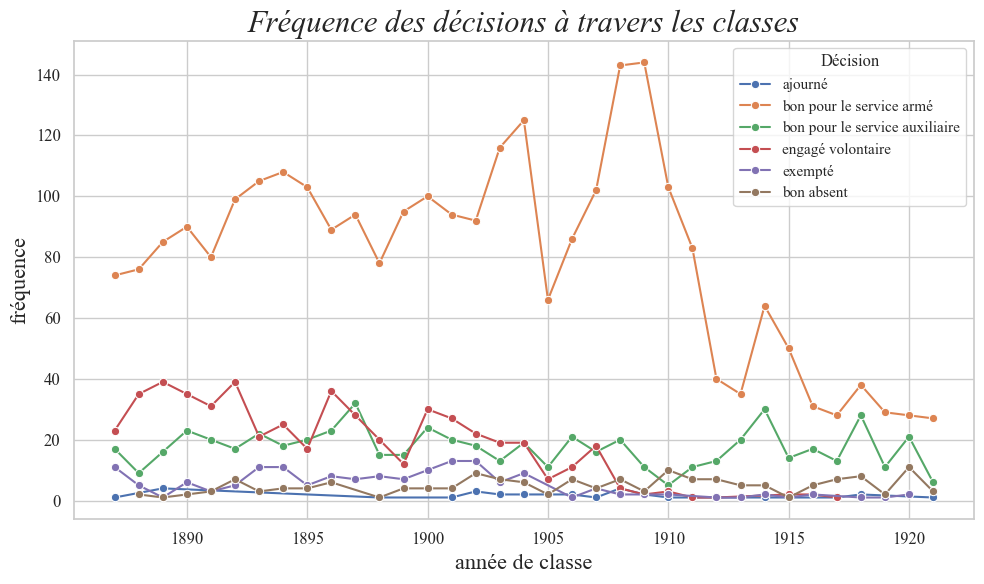

In [49]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['classement'] = df['decision'].apply(lambda x: extract_decision(x, DECISION) if isinstance(x, str) else x)
df['année_classe'] = df['num_mat'].apply(lambda x: extract_classe(x) if isinstance(x, str) else x)
df = df.apply(fill_classe, axis=1)
df['année_classe'] = pd.to_numeric(df['année_classe'], errors='coerce')

# Drop rows with missing values in the 'classe' column
df = df.dropna(subset=['année_classe'])

# Convert 'classe' column to integers
df['année_classe'] = df['année_classe'].astype(int)

# Filter the years between 1887 and 1921
clean_classe = df[(df['année_classe'] >= 1887) & (df['année_classe'] <= 1921)]

# Group the data by 'classe' and 'niveau_dinst', then count the occurrences
education_counts = clean_classe.groupby(['année_classe', 'classement']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=education_counts, x='année_classe', y='count', hue='classement', marker='o')

# Set labels and title
plt.xlabel('année de classe', fontsize=16)
plt.ylabel('fréquence', fontsize=16)
plt.title('Fréquence des décisions à travers les classes', style='italic', fontsize=22)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show legend
plt.legend(title='Décision')

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/decisionXclasse.png', dpi=300)
plt.show()

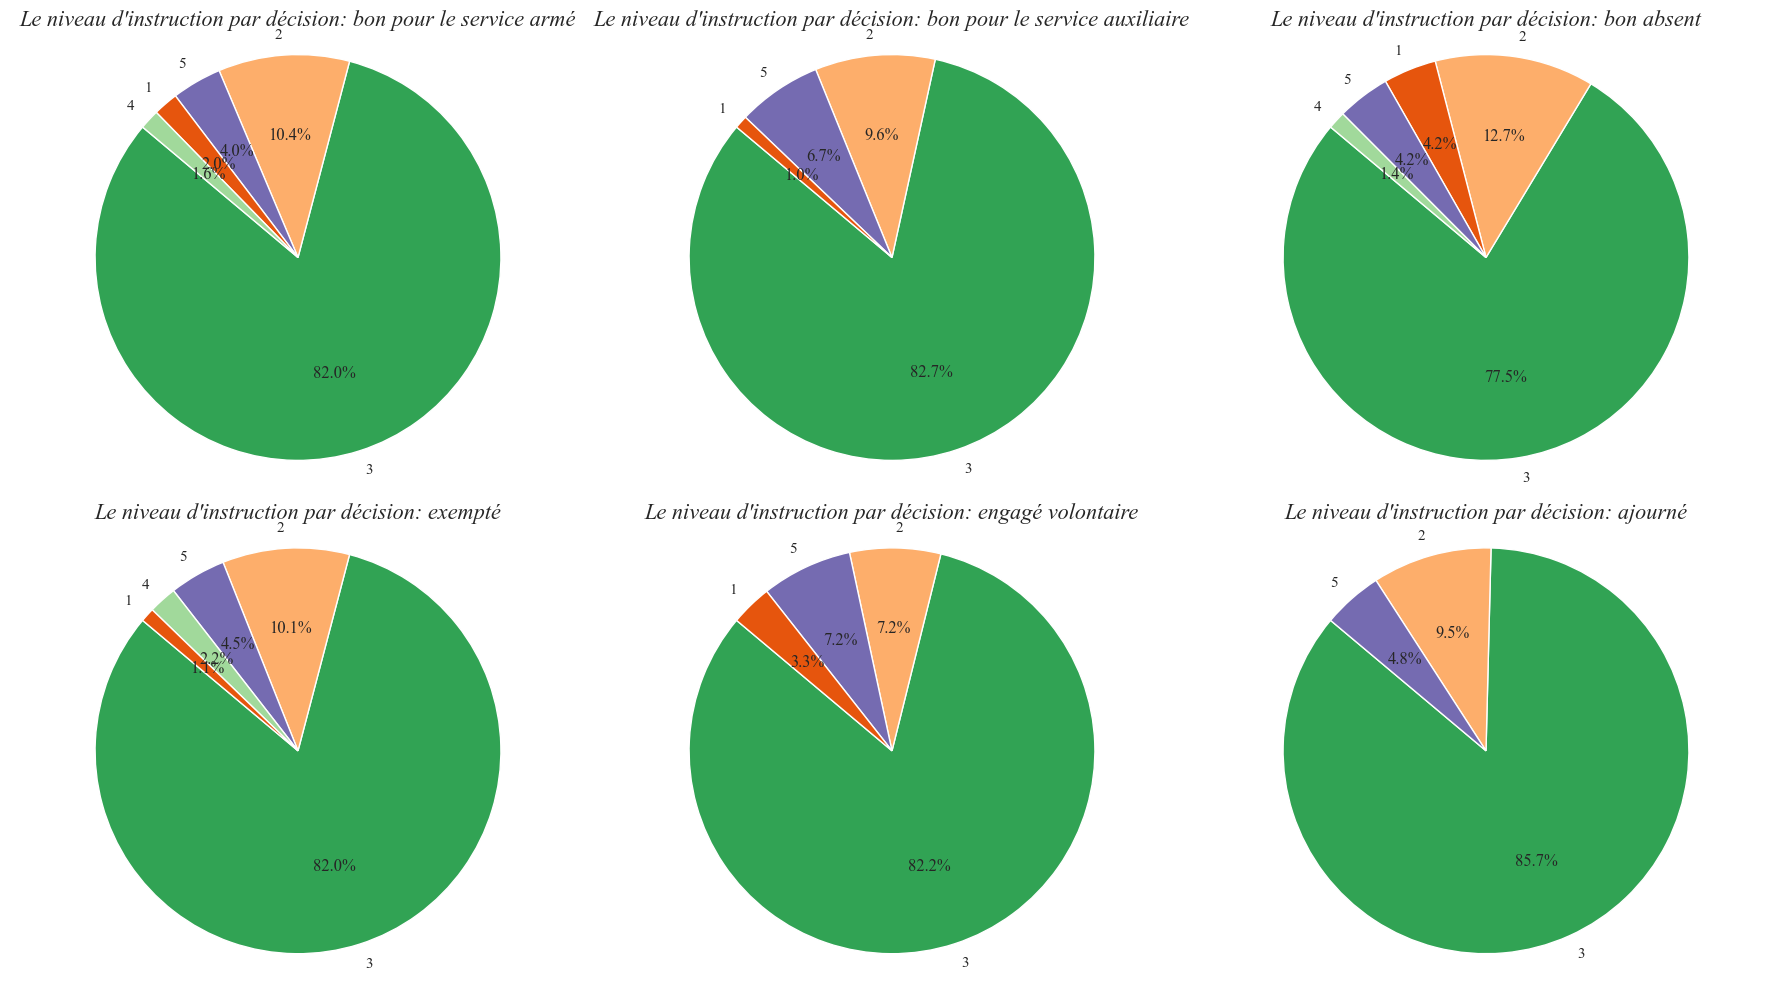

In [50]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df_other = pd.read_csv('data/primary/edited_geotagged_bertha.csv', sep=',')
df = pd.merge(df, df_other[['pays']], left_index=True, right_index=True)
df['classement'] = df['decision'].apply(lambda x: extract_decision(x, DECISION) if isinstance(x, str) else x)
df['niveau_dinst'] = df['instruction'].apply(lambda x: extract_inst(x) if isinstance(x, str) else x)
tab20c_palette = sns.color_palette('tab20c', n_colors=20)

# Define the colors for each education level
custom_colors = {
    '1': tab20c_palette[4],  # red
    '2': tab20c_palette[6],  # green
    '3': tab20c_palette[8],  # blue
    '4': tab20c_palette[10],  # orange
    '5': tab20c_palette[12]   # purple
}


# Filter out None and nan values from the 'classement' column
filtered_df = df.dropna(subset=['classement'])

# Define the decisions (classements)
decisions = filtered_df['classement'].unique()

# Set up the subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

plt.rcParams["font.family"] = "Times New Roman"

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each decision and create a pie chart
for i, decision in enumerate(decisions):
    # Filter the data for the current decision
    data = filtered_df[filtered_df['classement'] == decision]

    # Count occurrences of each education level for the current decision
    counts = data['niveau_dinst'].value_counts()

    # Calculate the total count
    total_count = counts.sum()

    # Filter out education levels with less than 1% of the total count
    counts = counts[counts / total_count >= 0.01]

    # Create a pie chart for the current decision
    colors = [custom_colors.get(level, 'gray') for level in counts.index]
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

    # Set the title for the pie chart
    axes[i].set_title(f"Le niveau d'instruction par décision: {decision}", style='italic', fontsize=16)

    # Equal aspect ratio ensures that pie is drawn as a circle
    axes[i].axis('equal')

# Adjust layout
plt.tight_layout()


# Show plot
plt.savefig('data/primary/figures/decisionXinst.png', dpi=300)
plt.show()

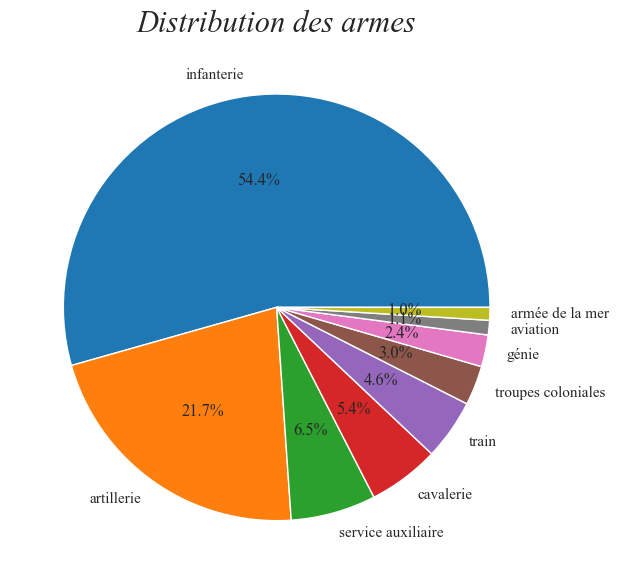

In [51]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['arme'] = df['affectation'].apply(lambda x: extract_arme(x.lower(), AFFECTATION) if isinstance (x, str) else x)
# Add medical corps and facotry corps to service auxiliaire
df['arme'] = df['arme'].apply(lambda x: "service auxiliaire" if isinstance(x, str) and x in ('affectations spéciales', 'corps medical') else x)
arme_count = df['arme'].value_counts()


plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
colors = sns.color_palette('tab10')
plt.rcParams["font.family"] = "Times New Roman"
plt.pie(arme_count, labels=arme_count.index, autopct='%1.1f%%', colors = colors)

# Add title
plt.title('Distribution des armes', style='italic', fontsize=22)

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/arme.png', dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

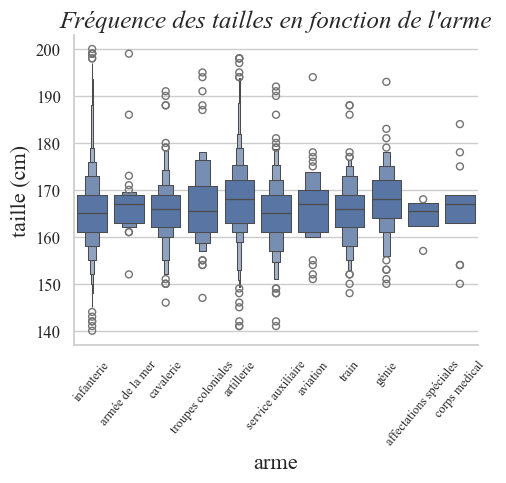

In [52]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df = extract_height(df)
df['arme'] = df['affectation'].apply(lambda x: extract_arme(x.lower(), AFFECTATION) if isinstance (x, str) else x)

# Plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
sns.catplot(data=df, x="arme", y="taille (cm)", kind="boxen")
plt.xticks(rotation=90, fontsize=10)

# Add title
plt.title("Fréquence des tailles en fonction de l'arme", style='italic', fontsize=18)

# Set labels and title
plt.xlabel('arme', fontsize=16)
plt.ylabel('taille (cm)', fontsize=16)

plt.xticks(rotation=50, fontsize=9)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/tailleXarme.png', dpi=300)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

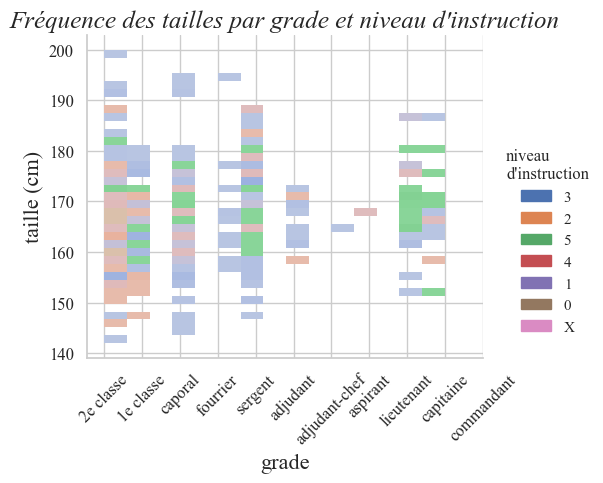

In [60]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
# On rajoute les informations de la base MPF
merged_df = pd.read_csv('data/primary/merged_mpf.csv', sep=',')
merged_df = merged_df[['labat_id', 'id_mention_intitule', 'classe', 'recrutement_matricule', 'id_recrutement_bureau_intitule',
                  'id_grade_intitule', 'id_unite_intitule', 'deces_jour_mois_annee', 'id_deces_lieu_intitule',
                  'id_deces_departement_intitule', 'id_deces_pays_intitule']]
merged_df.columns = ['mpf_' + col if col != 'labat_id' else col for col in merged_df.columns]
check_labat_ids(merged_df, df)
merged_df['labat_id'] = merged_df['labat_id'].astype(df['labat_id'].dtype)
df = df.join(merged_df.set_index('labat_id'), on='labat_id', how='left')

df = extract_height(df)
df['grade'] = df['details'].apply(lambda x: extract_grade(x.lower(), GRADE) if isinstance (x, str) else x)
df["niveau\nd'instruction"] = df['instruction'].apply(lambda x: extract_inst(x) if isinstance(x, str) else x)

# On met a jour les grades avec la base MPF
df['mpf_id_grade_intitule'] = df['mpf_id_grade_intitule'].apply(lambda x: 'soldat de 2e classe' if x == 'soldat' else x)
df['mpf_grade_normalized'] = df['mpf_id_grade_intitule'].apply(lambda x: extract_grade(x.lower(), GRADE) if isinstance (x, str) else x)

df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 6))
x = sns.displot(data=df, x="grade", y="taille (cm)", hue="niveau\nd'instruction")

sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

# Set the x-axis ticks explicitly to include all grades
ticks = range(1, 12)
x.ax.set_xticks(ticks)

# Set the x-axis tick labels using the dictionary
x.ax.set_xticklabels(labels=[grade_norme_dico.get(int(label.get_text()), label.get_text()) for label in x.ax.get_xticklabels()])
x.ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)

# Add title
plt.title("Fréquence des tailles par grade et niveau d'instruction", style='italic', fontsize=18)

# Rotate the x-axis labels and adjust font size
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('grade', fontsize=16)
plt.ylabel('taille (cm)', fontsize=16)

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/tailleXinstXgrade.png', dpi=300)
plt.show()

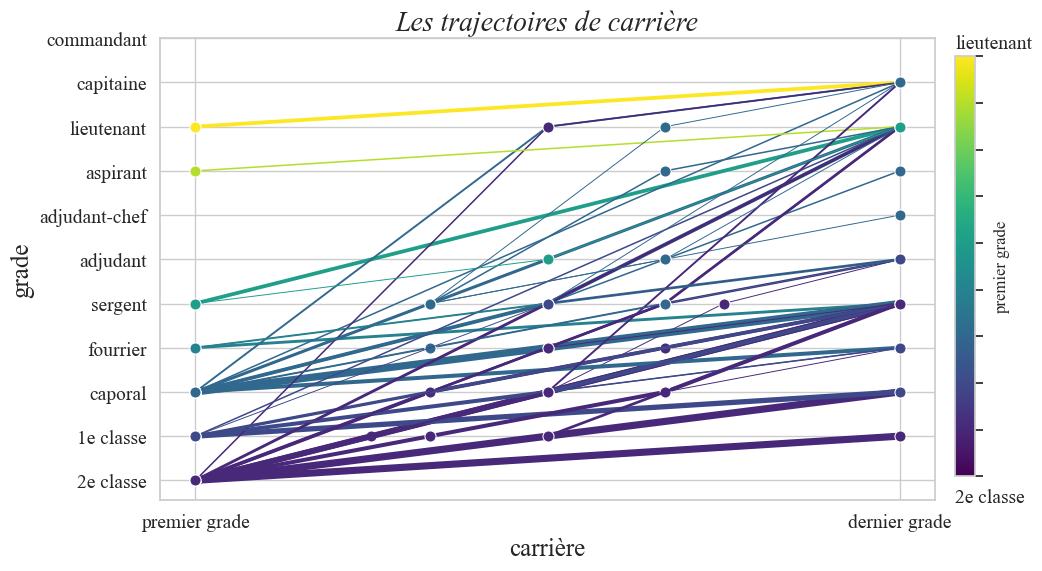

In [54]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['promotion_list'] = df['details'].apply(lambda x: extract_promotion_list(x.lower(), GRADE) if isinstance (x, str) else x)
df.at[4697, "promotion_list"] = [4, 5, 6] # This line corrects a trancription error where a single commandant is present and it ruins the graph
# Calculate x-coordinates for each rank value
def calculate_x_coordinates(promotion_list):
    if isinstance(promotion_list, list):
        start_x = 3
        end_x = 9
        num_ranks = len(promotion_list)
        x_coordinates = [start_x + (end_x - start_x) * i / (num_ranks - 1) for i in range(num_ranks)]
        return x_coordinates
    else:
        return None

# Calculate x-coordinates for each row
df['x_coordinates'] = df['promotion_list'].apply(calculate_x_coordinates)

# Drop rows with None in 'x_coordinates'
df = df.dropna(subset=['x_coordinates'])

# Count occurrences of each trajectory
trajectory_counts = Counter(tuple(row['promotion_list']) for _, row in df.iterrows())

# Filter out trajectories with only one occurrence
filtered_trajectories = {trajectory: count for trajectory, count in trajectory_counts.items() if count > 1}

plt.figure(figsize=(10, 6))

plt.rcParams["font.family"] = "Times New Roman"

# Plot trajectories
for promotion_list, count in filtered_trajectories.items():
    start_rank = promotion_list[0]  # Get the starting rank
    x_coordinates = df[df['promotion_list'].apply(tuple) == promotion_list]['x_coordinates'].iloc[0]
    y_values = promotion_list
    sns.lineplot(x=x_coordinates, y=y_values, linewidth=np.log(count), marker='o', markersize=8, color=plt.cm.viridis(start_rank / 9))

# Set plot labels and title
# Set the y-axis tick labels to the names of the different ranks
ticks = range(1, 12)
plt.yticks(ticks, [grade_norme_dico.get(tick, str(tick)) for tick in ticks], fontsize=14)

# Change the tick labels on the x-axis
plt.xticks([3, 9], ['premier grade', 'dernier grade'], fontsize=14)
plt.xlabel('carrière', fontsize=18)
plt.ylabel('grade', fontsize=18)
plt.title('Les trajectoires de carrière', style='italic', fontsize=20)

# Show grid
plt.grid(True)

# Add color bar
fig = plt.gcf()
color_map = plt.cm.ScalarMappable(cmap='viridis')
color_map.set_array([])
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
color_bar = plt.colorbar(color_map, ticks=np.linspace(0, 1, 10), cax=cax)
color_bar.ax.set_yticklabels([])
color_bar.set_label('premier grade')

# Adjust vertical spacing between '2e classe' and 'lieutenant'
ytick_labels = ['2e classe', '', '', '', '', '', '', '', '', 'lieutenant']
ytick_positions = np.linspace(0, 1.03, len(ytick_labels))
ytick_positions[0] = -0.05  # Adjust the position of '2e classe'

for y, label in zip(ytick_positions, ytick_labels):
    plt.text(0, y, label, ha='left', va='center', fontsize=14)

# Show plot
plt.savefig('data/primary/figures/career.png', dpi=300)
plt.show()


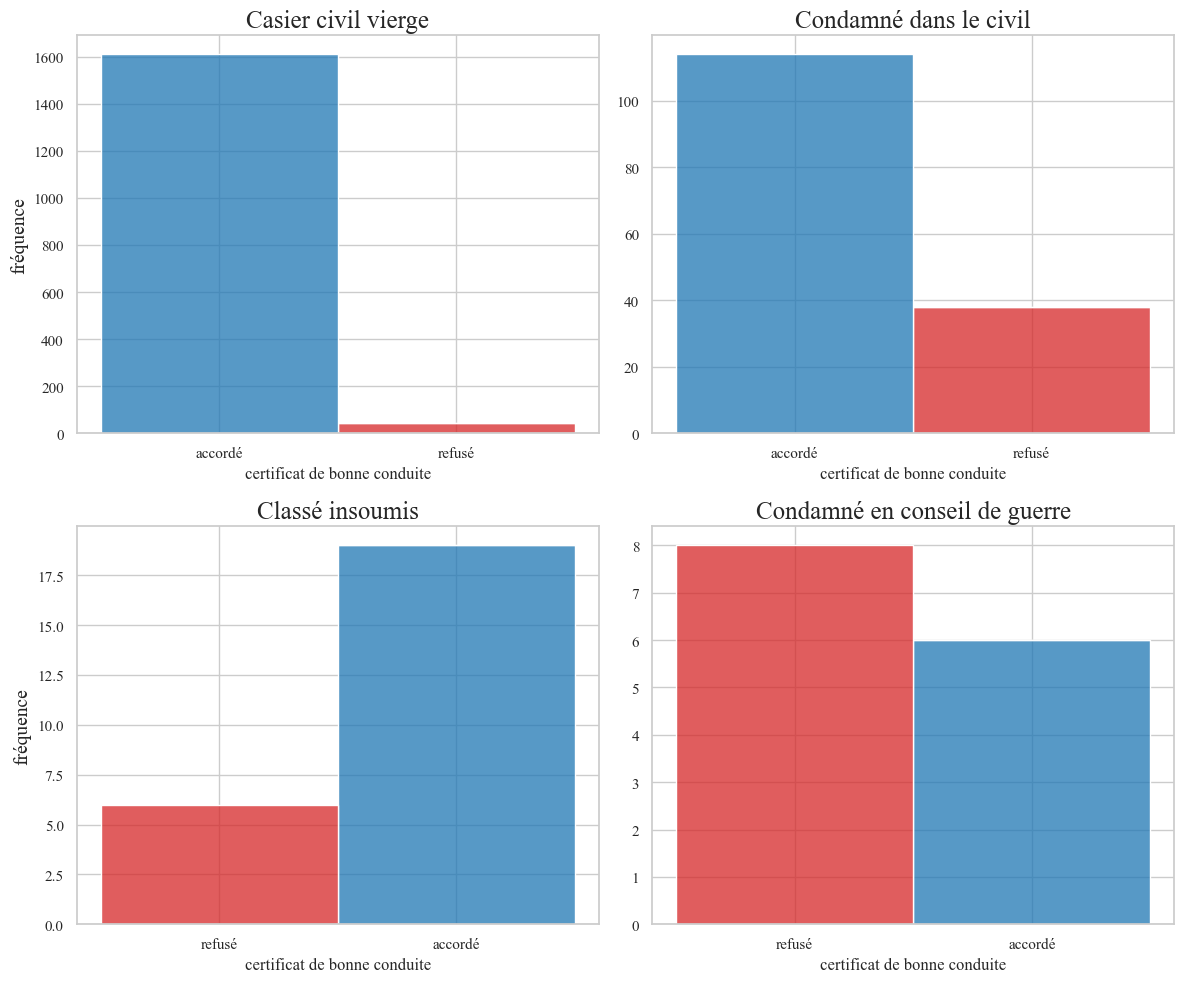

In [55]:
# I need to redo this figure with the conseil de guerre and civil condamnations in it too

df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['insoumis'] = df.apply(check_insoumis, axis=1)
df['criminel'] = df.apply(check_criminel, axis=1)
df['conseil'] = df.apply(check_conseil, axis=1)
df['arme'] = df['affectation'].apply(lambda x: extract_arme(x.lower(), AFFECTATION) if isinstance(x, str) else x)
df['certificat de bonne conduite'] = df['details'].apply(lambda x: extract_certificat(x.lower()) if isinstance(x, str) else x)
plt.rcParams["font.family"] = "Times New Roman"
# Filtered data for each histogram
non_condamne_certificat_counts = df[(df['criminel'] != 'condamné') ]['certificat de bonne conduite']
condamne_certificat_counts = df[df['criminel'] == 'condamné']['certificat de bonne conduite']
insoumis_certificat_counts = df[df['insoumis'] == 'insoumis']['certificat de bonne conduite']
conseil_certificat_counts = df[df['conseil'] == 'conseil']['certificat de bonne conduite']

# Define the color palette with pastel colors
palette = {'accordé': '#1F77B4', 'refusé': '#D62728'}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms
sns.histplot(data=df[df['criminel'] != 'condamné'], x='certificat de bonne conduite', hue='certificat de bonne conduite', discrete=True, multiple='stack', ax=axes[0, 0], palette=palette, legend=False)
axes[0, 0].set_title('Casier civil vierge', fontsize=18)
axes[0, 0].set_ylabel('fréquence', fontsize=14)

sns.histplot(data=df[df['criminel'] == 'condamné'], x='certificat de bonne conduite', hue='certificat de bonne conduite', discrete=True, multiple='stack', ax=axes[0, 1], palette=palette, legend=False)
axes[0, 1].set_title('Condamné dans le civil', fontsize=18)
axes[0, 1].set_ylabel('')

sns.histplot(data=df[df['insoumis'] == 'insoumis'], x='certificat de bonne conduite', hue='certificat de bonne conduite', discrete=True, multiple='stack', ax=axes[1, 0], palette=palette, legend=False)
axes[1, 0].set_title('Classé insoumis', fontsize=18)
axes[1, 0].set_ylabel('fréquence', fontsize=14)

sns.histplot(data=df[df['conseil'] == 'conseil'], x='certificat de bonne conduite', hue='certificat de bonne conduite', discrete=True, multiple='stack', ax=axes[1, 1], palette=palette, legend=False)
axes[1, 1].set_title('Condamné en conseil de guerre', fontsize=18)
axes[1, 1].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('data/primary/figures/certificat.png', dpi=300)
plt.show()

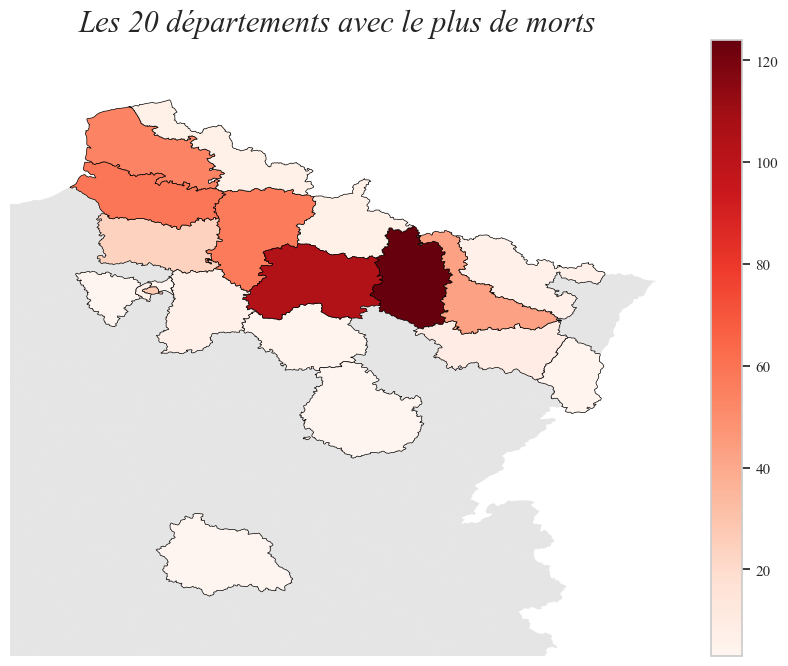

In [56]:
# Load GeoJSON file directly from URL
geojson_url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
france_departments = gpd.read_file(geojson_url)

# Create a DataFrame with the department names and their corresponding death counts
data = {
    'Department': [
        'Meuse', 'Marne', 'Pas-de-Calais', 'Aisne', 'Somme', 'Meurthe-et-Moselle', 'Oise',
        'Paris', 'Vosges', 'Ardennes', 'Nord', 'Seine-et-Marne', 'Hauts-de-Seine',
        'Moselle', 'Aube', 'Haut-Rhin', 'Côte-d\'Or', 'Puy-de-Dôme', 'Seine-Saint-Denis',
        'Yvelines'
    ],
    'Deaths': [124, 104, 54, 57, 59, 43, 24, 28, 9, 7, 7, 6, 6, 6, 4, 4, 3, 3, 3, 3]
}
df = pd.DataFrame(data)

# Merge the department boundaries with the death count data
merged_data = france_departments.merge(df, left_on='nom', right_on='Department', how='left')

# Create a new column indicating if the department is present in your dataset
merged_data['present_in_data'] = ~merged_data['Deaths'].isnull()

# Get the bounding box of departments present in your data
bbox = merged_data[merged_data['present_in_data']].total_bounds

# Add buffer to the bounding box
buffer = 0.7  # Adjust the buffer size as needed
bbox[0] -= buffer
bbox[1] -= buffer
bbox[2] += buffer
bbox[3] += buffer

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all France with department boundaries, set transparency for non-existing departments
france_departments.plot(ax=ax, color='gray', edgecolor='None', alpha=0.2)

# Plot departments present in your data
merged_data[merged_data['present_in_data']].plot(column='Deaths', cmap='Reds', linewidth=0.5, ax=ax, edgecolor='black', legend=True)

# Set plot limits to focus on the departments present in your dataset
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

# Remove the frame around the figure
ax.set_frame_on(False)

# Remove longitude and latitude grid
ax.set_xticks([])
ax.set_yticks([])

# Set aspect ratio to be equal
ax.set_aspect('equal')

# Set title
ax.set_title("Les 20 départements avec le plus de morts", style='italic', fontsize=22)


# Show the plot
plt.savefig('data/primary/figures/morts_carte.png', dpi=300)
plt.show()

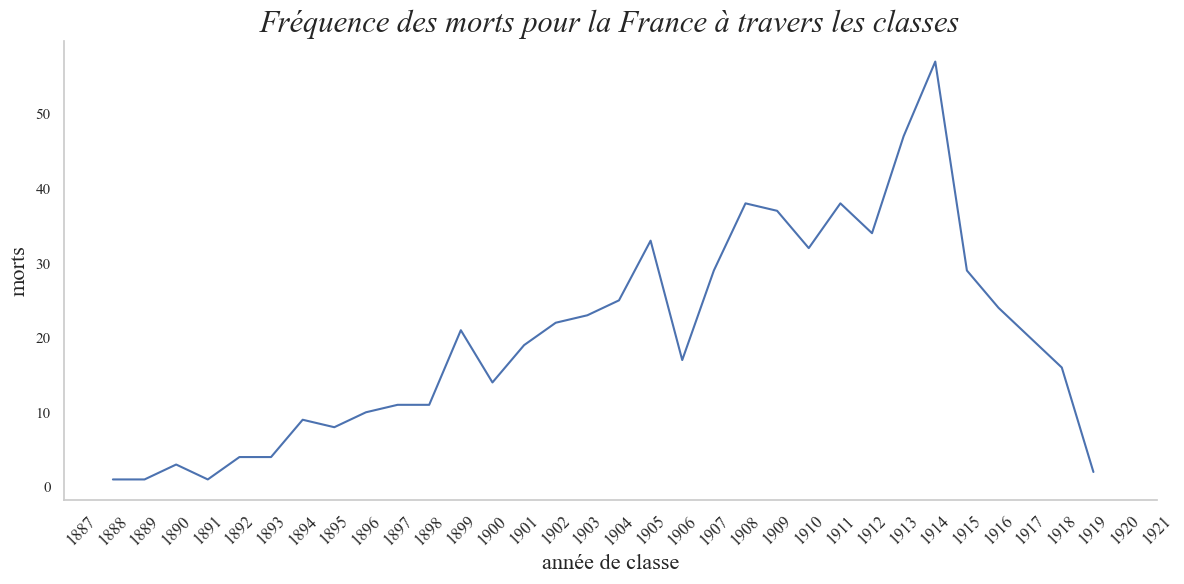

In [57]:
# CSV des registres matricules de la Seine
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df_other = pd.read_csv('data/primary/edited_geotagged_bertha.csv', sep=',') #On recupure l'information geocodée
df = pd.merge(df, df_other[['pays']], left_index=True, right_index=True)

df['année_classe'] = df['num_mat'].apply(lambda x: extract_classe(x) if isinstance(x, str) else x)
df = df.apply(fill_classe, axis=1)
df['année_classe'] = pd.to_numeric(df['année_classe'], errors='coerce')
df['mort'] = df['details'].apply(lambda x: extract_mort(x.lower()) if isinstance(x, str) else x)

# On rajoute les informations de la base MPF
merged_df = pd.read_csv('data/primary/merged_mpf.csv', sep=',')
merged_df = merged_df[['labat_id', 'id_mention_intitule', 'classe', 'recrutement_matricule', 'id_recrutement_bureau_intitule',
                  'id_grade_intitule', 'id_unite_intitule', 'deces_jour_mois_annee', 'id_deces_lieu_intitule',
                  'id_deces_departement_intitule', 'id_deces_pays_intitule']]
merged_df.columns = ['mpf_' + col if col != 'labat_id' else col for col in merged_df.columns]
check_labat_ids(merged_df, df)
merged_df['labat_id'] = merged_df['labat_id'].astype(df['labat_id'].dtype)
df = df.join(merged_df.set_index('labat_id'), on='labat_id', how='left')

# On nettoie les données de la base MPF
df['mpf_classe_cleaned'] = df['mpf_classe'].apply(lambda x: extract_year(x) if isinstance(x, str) else x)
df['mpf_classe_cleaned'] = pd.to_numeric(df['mpf_classe_cleaned'], errors='coerce')
df['année_classe'] = df.apply(lambda row: row['mpf_classe_cleaned'] if pd.notna(row['mpf_classe_cleaned']) else row['année_classe'], axis=1)
# Plotting
values = df[(df['mpf']==True) | (df['mort'].notna())]['mpf_classe_cleaned'].value_counts()

plt.figure(figsize=(12, 6))
sns.lineplot(x=values.index, y=values.values)
plt.xlabel('année de classe', fontsize=16)
plt.ylabel('morts', fontsize=16)
plt.title('Fréquence des morts pour la France à travers les classes', style='italic', fontsize=22)
# Despine the figure
sns.despine()
# Set x-axis ticks
plt.xticks(range(1887, 1922), rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.grid(False)  # Add grid for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('data/primary/figures/morts.png', dpi=300)
plt.show()

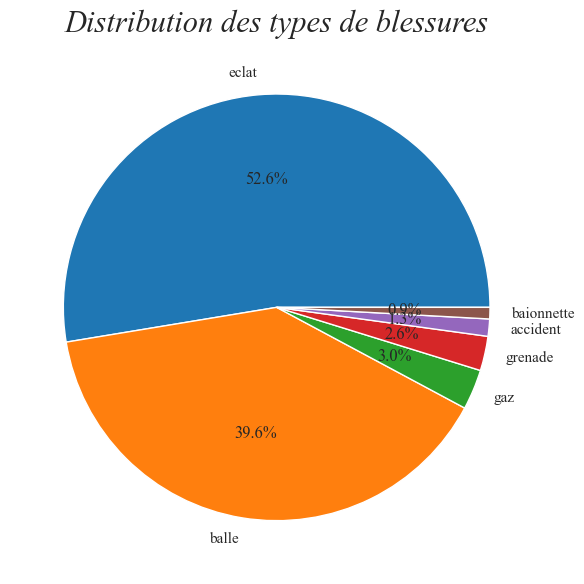

In [58]:
df = pd.read_csv('data/primary/big_bertha.csv', sep=',')
df['blesse'] = df.apply(check_blessure, axis=1)
df = find_blessure(df)

blesse_count = df['blesse_2'].value_counts()
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
colors = sns.color_palette('tab10')
plt.rcParams["font.family"] = "Times New Roman"
plt.pie(blesse_count, labels=blesse_count.index, autopct='%1.1f%%', colors = colors)

# Add title
plt.title('Distribution des types de blessures', style='italic', fontsize=22)

# Show plot
plt.tight_layout()
plt.savefig('data/primary/figures/blessures.png', dpi=300)
plt.show()